In [3]:
import numpy as np
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [4]:
class RegressionTreeFastMse():
    
    '''
    Класс RegressionTree с быстрым пересчетом ошибки. Сложность пересчета ошибки
    на каждой итерации составляет O(1).
    '''
    
    # объявляем характеристики класса
    def __init__(self, max_depth=3, min_size=10):
        
        self.max_depth = max_depth
        self.min_size = min_size
        self.value = 0
        self.feature_idx = -1
        self.feature_threshold = 0
        self.left = None
        self.right = None
        
    # процедура обучения - сюда передается обучающая выборка
    def fit(self, X, y):
        
        # начальное значение - среднее значение y
        self.value = y.mean()
        # начальная ошибка - mse между значением в листе (пока нет
        # разбиения, это среднее по всем объектам) и объектами
        base_error = ((y - self.value) ** 2).sum()
        error = base_error
        flag = 0
        
        # пришли в максимальную глубину
        if self.max_depth <= 1:
            return
    
        dim_shape = X.shape[1]
        
        left_value, right_value = 0, 0
        
        for feat in range(dim_shape):
            
            prev_error1, prev_error2 = base_error, 0 
            idxs = np.argsort(X[:, feat])
            
            # переменные для быстрого переброса суммы
            mean1, mean2 = y.mean(), 0
            sm1, sm2 = y.sum(), 0
            
            N = X.shape[0]
            N1, N2 = N, 0
            thres = 1
            
            while thres < N - 1:
                N1 -= 1
                N2 += 1

                idx = idxs[thres]
                x = X[idx, feat]
                
                # вычисляем дельты - по ним в основном будет делаться переброс
                delta1 = (sm1 - y[idx]) * 1.0 / N1 - mean1
                delta2 = (sm2 + y[idx]) * 1.0 / N2 - mean2
                
                # увеличиваем суммы
                sm1 -= y[idx]
                sm2 += y[idx]
                
                # пересчитываем ошибки за O(1)
                prev_error1 += (delta1**2) * N1 
                prev_error1 -= (y[idx] - mean1)**2 
                prev_error1 -= 2 * delta1 * (sm1 - mean1 * N1)
                mean1 = sm1/N1
                
                prev_error2 += (delta2**2) * N2 
                prev_error2 += (y[idx] - mean2)**2 
                prev_error2 -= 2 * delta2 * (sm2 - mean2 * N2)
                mean2 = sm2/N2
                
                # пропускаем близкие друг к другу значения
                if thres < N - 1 and np.abs(x - X[idxs[thres + 1], feat]) < 1e-5:
                    thres += 1
                    continue
                
                # 2 условия, чтобы осуществить сплит - уменьшение ошибки 
                # и минимальное кол-о эл-в в каждом листе
                if (prev_error1 + prev_error2 < error):
                    if (min(N1,N2) > self.min_size):
                    
                        # переопределяем самый лучший признак и границу по нему
                        self.feature_idx, self.feature_threshold = feat, x
                        # переопределяем значения в листах
                        left_value, right_value = mean1, mean2

                        # флаг - значит сделали хороший сплит
                        flag = 1
                        error = prev_error1 + prev_error2
                                     
                thres += 1
 
        # ничего не разделили, выходим
        if self.feature_idx == -1:
            return
        
        self.left = RegressionTreeFastMse(self.max_depth - 1)
        # print ("Левое поддерево с глубиной %d"%(self.max_depth - 1))
        self.left.value = left_value
        self.right = RegressionTreeFastMse(self.max_depth - 1)
        # print ("Правое поддерево с глубиной %d"%(self.max_depth - 1))
        self.right.value = right_value
        
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
    
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])
        
    def __predict(self, x):
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)
        
    def predict(self, X):
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])
            
        return y

In [5]:
data = datasets.fetch_california_housing()
X = np.array(data.data)
y = np.array(data.target)

In [14]:
print(y)

[4.526 3.585 3.521 ... 0.923 0.847 0.894]


In [6]:
%%time
A = RegressionTreeFastMse(2) # это наш алгоритм
A.fit(X,y)

Wall time: 2.02 s


In [7]:
%%time
model = DecisionTreeRegressor(max_depth=2)
 # из Sklearn
model.fit(X,y)

Wall time: 186 ms


In [8]:
from sklearn.model_selection import KFold

def get_metrics(X,y,n_folds=2, model=None):

    kf = KFold(n_splits=n_folds, shuffle=True)
    kf.get_n_splits(X)

    er_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        predict = model.predict(X_test)
        er_list.append(mean_squared_error(y_test, predict))
    
    return er_list

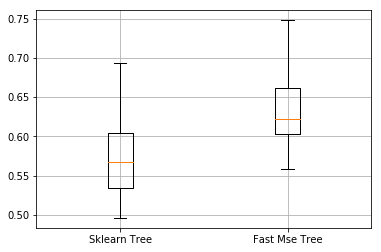

In [10]:
# ошибка такая маленькая, потому что целевая переменная не превышает 1

import matplotlib.pyplot as plt

data = datasets.fetch_california_housing()
X = np.array(data.data)
y = np.array(data.target)

er_sklearn_tree = get_metrics(X,y,30,DecisionTreeRegressor(max_depth=4, min_samples_leaf=10))
er_fast_mse_tree = get_metrics(X,y,30,RegressionTreeFastMse(4, min_size=10))

%matplotlib inline
data = [er_sklearn_tree, er_fast_mse_tree]
fig7, ax7 = plt.subplots()
ax7.set_title('')
ax7.boxplot(data, labels=['Sklearn Tree', 'Fast Mse Tree'])
plt.grid()
plt.show()

In [11]:
print(er_fast_mse_tree)



[0.6042004082935686, 0.5683236181577151, 0.6274685442555294, 0.5842168357285807, 0.6619490031568078, 0.5625905409985094, 0.6527888777373936, 0.7478671212774837, 0.5769862671762825, 0.6107878750928856, 0.6057115700506114, 0.6034201654112954, 0.7118436382951683, 0.6231879585778631, 0.5586490963607375, 0.589668929594331, 0.7244467240380864, 0.6062817842547914, 0.7267596305183467, 0.6868086368396866, 0.6029060960009648, 0.6199314616549375, 0.6818861602877277, 0.6514915880220066, 0.6614559527802069, 0.6095306129757173, 0.7009279566349907, 0.6050466796516779, 0.6284891694155109, 0.6298717164880316]
